In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df =  pd.read_csv(r"C:\Users\B K CHAITANYA\OneDrive\Desktop\scm-2020.csv",index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
print('Total row count =',len(df))
print('Types of data =\n',df.dtypes)
df.head(5)


Total row count = 168
Types of data =
 sales    int64
dtype: object


,sales
Date,
2007-01-01,589
2007-02-01,561
2007-03-01,640
2007-04-01,656
2007-05-01,727


<AxesSubplot:xlabel='Date'>

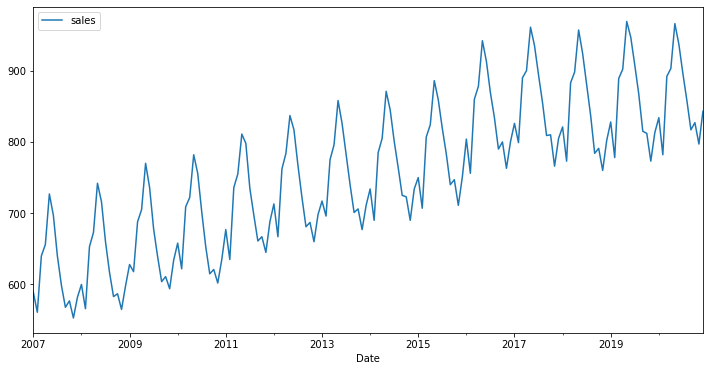

In [4]:
df.columns=['sales']
df.plot(figsize=(12,6))


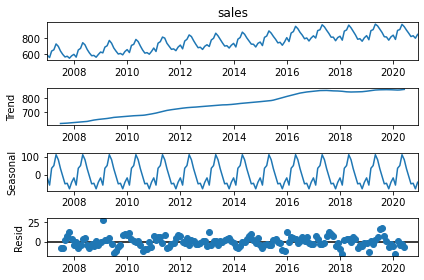

In [5]:
#checking trend,seasonality and 
from statsmodels.tsa.seasonal import seasonal_decompose
subplots = seasonal_decompose(df['sales'])
subplots.plot();

In [6]:
#Augmented Dicky fuller test (check for stationarity)
from statsmodels.tsa.stattools import adfuller
def ADF(dataset):
     result = adfuller(dataset, autolag = 'AIC') 
     print('ADF Statistic: %f' % result[0])
     print('P value: %f' % result[1])
     print('Number of Lags: %f' % result[2])
     print("Num Of Observations Used For ADF Regression:",      result[3])
     print("Critical Values :")
     for key, val in result[4].items():
         print("\t",key, ": ", val)
ADF(df['sales'])

#If p< 0.05 ; Data is stationary
#If p>0.05; Data is not stationary

ADF Statistic: -1.303812
P value: 0.627427
Number of Lags: 13.000000
Num Of Observations Used For ADF Regression: 154
Critical Values :
	 1% :  -3.473542528196209
	 5% :  -2.880497674144038
	 10% :  -2.576878053634677


In [8]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(x, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1211.487, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1087.468, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1141.361, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1209.693, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1087.838, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1088.100, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1089.788, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1085.469, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1085.840, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1086.101, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1139.475, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1087.790, Time=0.19 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.533 seconds


In [9]:
print(df.shape)
train=df.iloc[:-36]
test=df.iloc[-36:]
print(train.shape,test.shape)
df.head()

(168, 1)
(132, 1) (36, 1)


,sales
Date,
2007-01-01,589
2007-02-01,561
2007-03-01,640
2007-04-01,656
2007-05-01,727


In [10]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train,order=(0, 1, 2),seasonal_order=(0,1,2,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -408.281
Date:                            Thu, 02 Dec 2021   AIC                            826.562
Time:                                    16:54:24   BIC                            840.458
Sample:                                01-01-2007   HQIC                           832.205
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3388      0.107     -3.177      0.001      -0.548      -0.130
ma.L2          0.0649      0.094      0.690      0.490      -0.120       0.249
ma.S.L12      -0.6222      0.095     -6.576      0.000      -0.808      -0.437
ma.S.L24       0.0371      0.096      0.386      0.700      -0.151       0.226
sigma2        53.3998      5.509      9.693      0.000      42.602      64.197
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                51.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.02
Prob(H) (two-sided):                  0.96   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

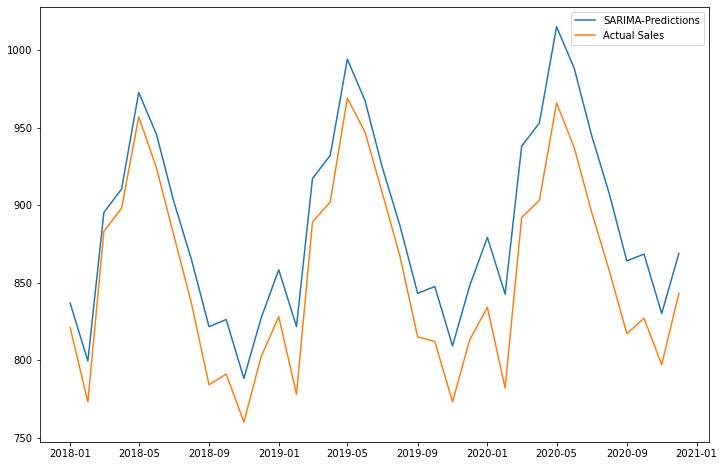

In [11]:
start=len(train)
end=len(train)+len(test)-1
# df['forecast']=results.predict(start=start,end=end,dynamic=True)
# df[['test','forecast']].plot(figsize=(12,8))
sarima_pred=results.predict(start=start,end=end,dynamic=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(sarima_pred,label='SARIMA-Predictions')
plt.plot(test,label='Actual Sales')
plt.legend(loc="upper right")
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [13]:
RMSE_sarima=sqrt(mean_squared_error(sarima_pred,test))
MAE_sarima = mean_absolute_error(sarima_pred,test)

y_test, y_pred = np.array(test), np.array(sarima_pred)
MAPE_sarima=np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Mean Squared Error for arima is:',RMSE_sarima)
print('Mean Absolute Deviation for arima Model is:',MAE_sarima)
print('MAPE for Holts Winter Model is:',MAPE_sarima)


Mean Squared Error for arima is: 34.97381630989743
Mean Absolute Deviation for arima Model is: 32.68459114931303
MAPE for Holts Winter Model is: 8.748795523090198


In [14]:
y_pred

array([ 836.75869454,  799.40440417,  895.19277501,  910.40989641,
        972.63017389,  945.67701633,  902.82023587,  865.10964152,
        821.53423813,  826.15385141,  788.20834814,  826.9597436 ,
        858.23653548,  821.60475263,  917.13004224,  932.03423382,
        994.18588373,  967.28360382,  924.53854201,  886.75935913,
        843.03135284,  847.44833907,  809.13013298,  847.89017102,
        879.18077685,  842.54076386,  938.06605346,  952.97024504,
       1015.12189496,  988.21961504,  945.47455324,  907.69537036,
        863.96736406,  868.3843503 ,  830.0661442 ,  868.82618224])

In [15]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]


In [16]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [17]:
future_datest_df

,sales
2021-01-01,NaN
2021-02-01,NaN
2021-03-01,NaN
2021-04-01,NaN
2021-05-01,NaN
2021-06-01,NaN
2021-07-01,NaN
2021-08-01,NaN
2021-09-01,NaN
2021-10-01,NaN


In [22]:
future_df=pd.concat([df,future_datest_df])
future_df

,sales
2007-01-01,589
2007-02-01,561
2007-03-01,640
2007-04-01,656
2007-05-01,727
...,...
2022-07-01,NaN
2022-08-01,NaN
2022-09-01,NaN
2022-10-01,NaN


C:\Users\B K CHAITANYA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:>

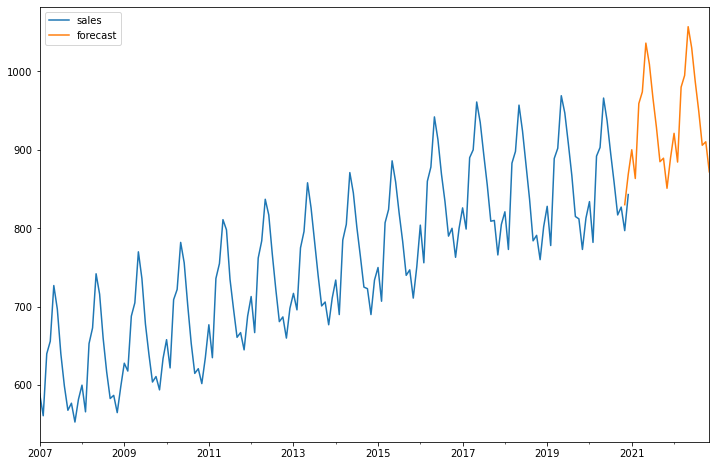

In [30]:
future_df['forecast'] = results.predict(start = 166, end = 194, dynamic= True)  
future_df[['sales', 'forecast']].plot(figsize=(12, 8))

In [31]:
print(future_df['forecast'])

2007-01-01   NaN         
2007-02-01   NaN         
2007-03-01   NaN         
2007-04-01   NaN         
2007-05-01   NaN         
2007-06-01   NaN         
2007-07-01   NaN         
2007-08-01   NaN         
2007-09-01   NaN         
2007-10-01   NaN         
2007-11-01   NaN         
2007-12-01   NaN         
2008-01-01   NaN         
2008-02-01   NaN         
2008-03-01   NaN         
2008-04-01   NaN         
2008-05-01   NaN         
2008-06-01   NaN         
2008-07-01   NaN         
2008-08-01   NaN         
2008-09-01   NaN         
2008-10-01   NaN         
2008-11-01   NaN         
2008-12-01   NaN         
2009-01-01   NaN         
2009-02-01   NaN         
2009-03-01   NaN         
2009-04-01   NaN         
2009-05-01   NaN         
2009-06-01   NaN         
2009-07-01   NaN         
2009-08-01   NaN         
2009-09-01   NaN         
2009-10-01   NaN         
2009-11-01   NaN         
2009-12-01   NaN         
2010-01-01   NaN         
2010-02-01   NaN         
2010-03-01  

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(future_df)

<ipython-input-32-3c8c6032715c>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,sales,forecast
2007-01-01,589,NaN
2007-02-01,561,NaN
2007-03-01,640,NaN
2007-04-01,656,NaN
2007-05-01,727,NaN
2007-06-01,697,NaN
2007-07-01,640,NaN
2007-08-01,599,NaN
2007-09-01,568,NaN
2007-10-01,577,NaN
